In [1]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import keras.optimizers as opts
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
#Paths to access the necessary data
path_to_dataset_folder = 'C:/Users/Dimiexe/Desktop/DATAsets'
tree_meta_feature_path = path_to_dataset_folder + '/DATA/tree_metafeatures_for_test_CSVs'
ground_truth_path = path_to_dataset_folder + '/DATA/ground_truth'
metaModel_data_path = path_to_dataset_folder + '/DATA/metaModel_Datasets'
regularization_path = path_to_dataset_folder + '/regularization'
normalization_path = path_to_dataset_folder + '/normalization'
model_path = path_to_dataset_folder + '/final_models'
manual_meta_feature_path = path_to_dataset_folder + '/DATA/manual_metafeatures_for_test_CSVs'

In [2]:
#Combines the extracted metafeatures and ground truth for each dataset into a new dataset.
#Every line contains the 16 metafeatures + 2 (3 for xgboost) ground truth hyperparameters and represents
#a different dataset. Returns that unified dataset.
def build_dataSet_DL(tree_meta_feature_path, ground_truth_path, manual_meta_feature_path = None,
                     algo = 'RF', method = 'drop', eco = True
                    ):
    for i,f in enumerate(os.listdir(tree_meta_feature_path + '/' + method)):
        line = pd.read_csv(tree_meta_feature_path + '/' + method + '/' + f,
                           names = ['TreeDiam', 'TreeHeight', 'TotalNodes', 'TotalLeaves',
                                    'maxNodePerLevel', 'meanNodePerLevel', 'stdNodePerLevel',
                                    'ShortBranch', 'meanBranch', 'stdBranch','maxFeatureFreq',
                                    'minFeatureFreq', 'meanFeatureFreq', 'stdFeatureFreq','NaNsPerLine'
                                   ],
                           header = None, sep=',')
        if not manual_meta_feature_path == None:
            line2 = pd.read_csv(manual_meta_feature_path + '/' + method + '/' + f,
                                names = ['nr_inst', 'nr_attr', 'inst_to_attr', 'nr_cat', 'nr_num', 'cat_to_num',
                                         'nr_class_mean', 'nr_class_std', 'cor_mean', 'cor_std', 'cov_mean', 'cov_std',
                                         'kurtosis_mean', 'kurtosis_std', 'mad_mean', 'mad_std', 'max_mean', 'max_std',
                                         'mean_mean', 'mean_std', 'median_mean', 'median_std', 'min_mean', 'min_std',
                                         'std_mean', 'std_std', 'skew_mean', 'skew_std','var_mean', 'var_std'
                                        ],
                                header = None, sep=',')
            line = pd.concat([line, line2], ignore_index = False, axis = 1)
        line2 = pd.read_csv(ground_truth_path + '/' + algo + '/' + f, header = 0, sep=',')
        if algo == 'GLM':
            line2.drop(line2.columns[2:], axis = 1, inplace = True)
        elif algo == 'RF':
            if eco:
                line2.drop(line2.columns[:3], axis = 1, inplace = True)
            line2.drop(line2.columns[2:], axis = 1, inplace = True)                
        elif algo == 'XGboost':
            if eco:
                line2.drop(line2.columns[:4], axis = 1, inplace = True)
            line2.drop(line2.columns[3:], axis = 1, inplace = True)
        else:
            print("\n>>> Algorithm '" + algo + "' not valid. <<<")
            return None
        line = pd.concat([line, line2], ignore_index = False, axis = 1)
        if i==0:
            df = line
        else:
            df = pd.concat([df, line], ignore_index = True, axis = 0)
    df.to_csv(metaModel_data_path + '/' + algo + '_' + method + '.csv', sep =',', index = False)
    return df

In [3]:
def regularize_dataset(data, algo, method, regularize_y, regularization_path):
    regularization_means = pd.read_csv(regularization_path + '/regularization_means_' + algo + '_' + method + '.csv')
    regularization_stds = pd.read_csv(regularization_path + '/regularization_stds_' + algo + '_' + method + '.csv')
    if regularize_y:
        L = data.columns
    else:
        if algo in ['RF', 'GLM']:
            L = data.columns[0:-2]
        elif algo == 'XGboost':
            L = data.columns[0:-3]
    for j in L:
        for i,x in enumerate(data.loc[:,j]):
            data.loc[i,j] = (x-regularization_means.loc[0,j])/regularization_stds.loc[0,j]
    return data

def normalize_dataset(data, algo, method, normalize_y, normalization_path):
    normal_mins = pd.read_csv(normalization_path + '/normalizaton_mins_' + algo + '_' + method + '.csv')
    normal_maxes = pd.read_csv(normalization_path + '/normalizaton_maxes_' + algo + '_' + method + '.csv')
    if normalize_y:
        L = data.columns
    else:
        if algo in ['RF', 'GLM']:
            L = data.columns[0:-2]
        elif algo == 'XGboost':
            L = data.columns[0:-3]
    for j in L:
        for i,x in enumerate(data.loc[:,j]):
            data.loc[i,j] = ( x-normal_mins.loc[0,j] ) / (normal_maxes.loc[0,j] - normal_mins.loc[0,j])
    return data

def deregularize_preds(preds, algo, method, regularization_path):
    regularization_means = pd.read_csv(regularization_path + '/regularization_means_' + algo + '_' + method + '.csv')
    regularization_stds = pd.read_csv(regularization_path + '/regularization_stds_' + algo + '_' + method + '.csv')
    if algo in ['RF','GLM']:
        L = [-1,-2]
    elif algo == 'XGboost':
        L = [-1,-2,-3]
    for j in L:
        for i,x in enumerate(preds[:,j]):
            preds[i,j] = (x * regularization_stds.iloc[0,j] + regularization_means.iloc[0,j])
    return preds

def denormalize_preds(preds, algo, method, normalization_path):    
    normal_mins = pd.read_csv(normalization_path + '/normalizaton_mins_' + algo + '_' + method + '.csv')
    normal_maxes = pd.read_csv(normalization_path + '/normalizaton_maxes_' + algo + '_' + method + '.csv')
    if algo in ['RF','GLM']:
        L = [-1,-2]
    elif algo == 'XGboost':
        L = [-1,-2,-3]
    for j in L:
        for i,x in enumerate(preds[:,j]):
            preds[i,j] = x * (normal_maxes.iloc[0,j] - normal_mins.iloc[0,j]) + normal_mins.iloc[0,j]
    return preds

# Standardize data and splits to predictors (x) and targets (y)
# Standardization options:
# 'regularize' for regularization (mean = 0, std = 1)
# 'normalize' for normalization (range of values in [0,1])
def Data_prep(data, algo, method, regularization_path, normalization_path, standardize = 'regularize', regularize_y = False, normalize_y = False):
    if standardize == 'regularize':
        data = regularize_dataset(data, algo, method, regularize_y, regularization_path)
    elif standardize == 'normalize':
        data = normalize_dataset(data, algo, method, normalize_y, normalization_path)
    else:
        print('No regularization performed. Results will be sub-optimal.')
    data = data.values
    if algo in ['RF', 'GLM']:
        y = data[:, -2:]
        x = data[:, 0:-2]
    elif algo == 'XGboost':
        y = data[:, -3:]
        x = data[:, 0:-3]
    else:
        print('\n>>> Not supported algorithm. Returning None! <<<')
        return None
    return x, y

In [4]:
#Returns "train" and "test" pandas.DataFrames split acording to the provided ratio.
def split_train_test_indices(dataset, split_ratio = .15):
    import random
    rows = dataset.shape[0]
    test_rows = round(rows * split_ratio)
    train_rows = rows - test_rows
    
    #Generate train_data
    train_indices = []
    while len(train_indices) < train_rows:
        candidate = random.randint(0, rows-1)
        if candidate not in train_indices:
            train_indices.append(candidate)
    
    #Generate test data
    test_indices = []
    for j in range(rows):
        if j not in train_indices:
            test_indices.append(j)    
    return train_indices, test_indices

def split_train_test(dataset, split_ratio = .15):
    import random
    rows = len(dataset)
    test_rows = round(rows * split_ratio)
    train_rows = rows - test_rows
    
    #Generate train_data
    train_indices = []
    while len(train_indices) < train_rows:
        candidate = random.randint(0, rows-1)
        if candidate not in train_indices:
            train_indices.append(candidate)
    train = dataset.loc[train_indices,:]
    train.reset_index(drop=True, inplace = True)
    
    #Generate test data
    test_indices = []
    for j in range(rows):
        if j not in train_indices:
            test_indices.append(j)
    test = dataset.loc[test_indices,:]
    test.reset_index(drop=True, inplace = True)    
    return train, test

In [5]:
#Trains and returns the deep learning estimator for the specified algorithm.
#The below code is based on the code found at:
#https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/
#and is tweked acording to the needs of this project.

# define function to make base model
def create_model(input_dim = 15, algo = 'GLM', hidden = 5, two_layers = False, half_on_second = False):
    # create model
    model = Sequential()
    model.add(Dense(hidden, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    if two_layers:
        if half_on_second:
            model.add(Dense(round(hidden/2), kernel_initializer='normal'))
        else:
            model.add(Dense(hidden, kernel_initializer='normal'))
    if algo in ['GLM', 'RF']:
        model.add(Dense(2, kernel_initializer='normal'))
    elif algo == 'XGboost':
        model.add(Dense(3, kernel_initializer='normal'))
    else:
        print("\n>>> Algorithm '" + algo + "' not valid. <<<")
        return None
    # Compile model
    model.compile(loss = 'mse', optimizer = opts.Adam(learning_rate=0.01))
    return model

In [6]:
def fix_preds_calcs(param_vector, single_pred):
    param_vector2 = [abs(x - single_pred) for x in param_vector]
    temp = 0   #Store parameter value
    ind = 100000  #Store parameter comparison value
    for i,pa in enumerate(param_vector2):
        if pa < ind:
            ind = pa
            temp = param_vector[i]
    return temp

def fix_preds_NN(preds, algo, lambdas):
    in_preds = pd.DataFrame({})
    length = len(preds)
    temp0 = []
    temp1 = []
    temp2 = []
    if algo == 'GLM':
        y = range(0, 1100, 125)
        param_alpha = [x / 1000 for x in y]
        param_lambda = set(lambdas)
        param_lambda = list(param_lambda)  #Create list of unique train lambda values
        for i in range(length):
            temp0.append(fix_preds_calcs(param_alpha, preds[i,0]))
            temp1.append(fix_preds_calcs(param_lambda, preds[i,1]))
        in_preds['A'] = temp0
        in_preds['B'] = temp1
                
    elif algo =='RF':
        param_tree = [25,50,75,100,200,300,400,500]
        param_depth = [20,40,60,80]
        for i in range(length):
            temp0.append(fix_preds_calcs(param_tree, preds[i,0]))
            temp1.append(fix_preds_calcs(param_depth, preds[i,1]))
        in_preds['A'] = temp0
        in_preds['B'] = temp1
        
    elif algo == 'XGboost':
        for i in range(length):
            param_tree = [25,50,100,200]
            param_depth = [6,10,15]
            colsample_bytree = [.6,.7,.8,.9]
            temp0.append(fix_preds_calcs(param_tree, preds[i,0]))
            temp1.append(fix_preds_calcs(param_depth, preds[i,1]))
            temp2.append(fix_preds_calcs(colsample_bytree, preds[i,2]))
        in_preds['A'] = temp0
        in_preds['B'] = temp1
        in_preds['C'] = temp2
    return in_preds.values

In [7]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 300
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

lr = LearningRateScheduler(lr_scheduler, verbose=1)

In [ ]:

#Run >>> ONCE <<< to extract regularization statistics,
#and build meta-learning datasets.

def extract_normalization_info(data, algo, method, regularization_path, normalization_path):
    mean_dict = {}
    std_dict = {}
    min_dict = {}
    max_dict = {}
    for i,c in enumerate(data.columns):
        meanV = data.iloc[:,i].mean()
        stdV = data.iloc[:,i].std()
        minV = data.iloc[:,i].min()
        maxV = data.iloc[:,i].max()
        mean_dict[c] = [meanV]
        std_dict[c] = [stdV]
        min_dict[c] = [minV]
        max_dict[c] = [maxV]
    temp = pd.DataFrame(mean_dict)
    temp.to_csv(regularization_path + '/regularization_means_' + algo + '_' + method + '.csv', index =False)
    temp = pd.DataFrame(std_dict)
    temp.to_csv(regularization_path + '/regularization_stds_' + algo + '_' + method + '.csv', index =False)
    temp = pd.DataFrame(min_dict)
    temp.to_csv(normalization_path + '/normalizaton_mins_' + algo + '_' + method + '.csv', index =False)
    temp = pd.DataFrame(max_dict)
    temp.to_csv(normalization_path + '/normalizaton_maxes_' + algo + '_' + method + '.csv', index =False)
        
for algo in ['RF','GLM','XGboost']:
    for method in ['drop', 'mean', 'median']:
        dataset = build_dataSet_DL(tree_meta_feature_path,
                                   ground_truth_path,
                                   manual_meta_feature_path,
                                   algo,
                                   method,
                                   eco = True
                                  )
        extract_normalization_info(dataset,
                                   algo,
                                   method,
                                   regularization_path,
                                   normalization_path
                                  )

In [ ]:
#--------------------------------------------------------------------------
# THIS WAS USED TO EXPERIMENT FOR THE NUMBER OF NEURONS IN THE HIDDEN LAYER
#              >>> NOT TO BE USED ANYMORE <<<
# USE THE FINAL SEGMENT BELOW FOR TRAINING THE FINAL MODELS
#--------------------------------------------------------------------------
#Create all datasets for the Neural Networks.
#3 datasets are generated per algorithm, 1 for each NaN imputation method (drop,mean,median).
kfold = KFold(n_splits=10)
two_layers = False
meta = 'tree'
es = EarlyStopping(monitor='loss', mode='min', patience = 50, verbose = 0)
for standardize in  ['regularize', 'normalize']:
    for standardize_y in [False, True]:
        if standardize == 'regularize':
            if not standardize_y:
                print('################## Experiment 1 #####################')
                print('metafeature set:',meta)
                print('standardize: regularize')
                print('regularize_y: False')
            else:
                print('################## Experiment 2 #####################')
                print('metafeature set:',meta)
                print('standardize: regularize')
                print('regularize_y: True')
        elif standardize == 'normalize':
            if not standardize_y:
                print('################## Experiment 3 #####################')
                print('metafeature set:',meta)
                print('standardize: normalize')
                print('normalize_y: False')
            else:
                print('################## Experiment 4 #####################')
                print('metafeature set:',meta)
                print('standardize: normalize')
                print('normalize_y: True')
        #print('two_layers =',two_layers)

        for algo in ['RF','XGboost','GLM']:
            print('------ Algo = ' + algo + ' ------')
            for method in ['drop', 'mean', 'median']:
                print('NaN method: ' + method)
                if meta == 'tree':
                    input_dim = 15
                    dataset = build_dataSet_DL(tree_meta_feature_path, ground_truth_path,
                                               algo = algo, method = method, eco = True
                                              )
                elif meta == 'all':
                    input_dim = 45
                    dataset = build_dataSet_DL(tree_meta_feature_path, ground_truth_path,
                                               manual_meta_feature_path = manual_meta_feature_path,
                                               algo = algo, method = method, eco = True
                                              )
                x, y = Data_prep(dataset, algo, method,
                                 regularization_path, normalization_path,
                                 standardize = standardize,
                                 regularize_y = standardize_y,
                                 normalize_y = standardize_y
                                )
                for hidden in [1,2,3,4,5]:
                    print(str(hidden) + ' hidden neurons')
                    temp =[]
                    for i in range(10):
                        estimator = KerasRegressor(build_fn = create_model,
                                                   input_dim = input_dim,
                                                   algo = algo,
                                                   hidden = hidden,
                                                   two_layers = two_layers
                                                  )
                        results = cross_val_score(estimator, X = x, y = y,
                                                  fit_params = {#'callbacks':[es],
                                                                'epochs':200,
                                                                'verbose':0,
                                                                'batch_size':5
                                                               },
                                                  cv = kfold,
                                                  scoring = 'neg_root_mean_squared_error')
                        #print(results)
                        temp = np.concatenate((temp,results))
                    print("Results: %.10f RMSE, %.10f std" % (abs(temp.mean()), temp.std()))
                print('')

In [ ]:
#--------------------------------------------------------------------------
#                             VERSION 2
# THIS WAS USED TO EXPERIMENT FOR THE NUMBER OF NEURONS IN THE HIDDEN LAYER
#              >>> NOT TO BE USED ANYMORE <<<
# USE THE FINAL SEGMENT BELOW FOR TRAINING THE FINAL MODELS
#                             VERSION 2
#--------------------------------------------------------------------------
#Create all datasets for the Neural Networks.
#3 datasets are generated per algorithm, 1 for each NaN imputation method (drop,mean,median).
kfold = KFold(n_splits=10)
standardize = 'normalize'
exp_i = 0
for standardize_y in [False, True]: #normalize_y
    for meta in ['tree', 'all']:
        if meta == 'tree':
            input_dim = 15
        else:
            input_dim = 45
        for two_layers in [False,True]:
            for hos in [False,True]:
                if two_layers:
                    exp_i+=1
                    print('################### Experiment ' + str(exp_i) + ' ###################')
                    print('standardize method:',standardize)
                    print('standardize_y:',standardize_y)
                    print('metafeature set:',meta)
                    print('two_layers =',two_layers)
                    if two_layers:
                        print('second layer has half neurons:',hos)

                    for algo in ['GLM', 'RF','XGboost']:
                        print('------ Algo = ' + algo + ' ------')
                        for method in ['drop', 'mean', 'median']:
                            print('NaN method: ' + method)
                            #Prepare the data
                            if meta == 'all':        
                                dataset = build_dataSet_DL(tree_meta_feature_path,
                                                           ground_truth_path,
                                                           manual_meta_feature_path = manual_meta_feature_path,
                                                           algo = algo, method = method
                                                          )
                            elif meta == 'tree':
                                dataset = build_dataSet_DL(tree_meta_feature_path,
                                                           ground_truth_path,
                                                           algo = algo, method = method
                                                          )
                            x, y = Data_prep(dataset, algo, method,
                                             regularization_path, normalization_path,
                                             standardize = standardize,
                                             regularize_y = standardize_y,
                                             normalize_y = standardize_y
                                            )
                            for hidden in [5,10,20]:
                                print(str(hidden) + ' hidden neurons')
                                temp =[]
                                for i in range(20):
                                    estimator = KerasRegressor(build_fn = create_model,
                                                               input_dim = input_dim,
                                                               algo = algo,
                                                               hidden = hidden,
                                                               two_layers = two_layers,
                                                               half_on_second = hos
                                                              )
                                    results = cross_val_score(estimator, X = x, y = y,
                                                              fit_params = {'epochs':100,
                                                                            'verbose':0,
                                                                            'batch_size':5
                                                                           },
                                                              cv = kfold,
                                                              scoring = 'neg_root_mean_squared_error'
                                                             )
                                    #print(results)
                                    temp = np.concatenate((temp,results))
                                print("Results: %.10f RMSE, %.10f std" % (abs(temp.mean()), temp.std()))
                    print('')

In [8]:
#Run this once for each cross validation AND prediction session, as the row
#indices are stored in "train_indices" and "test_indices" and are the same
#for both crossvalidation and fit processes.

manual_indices = True

split_ratio = .15 #Training/Testing set ratio.
kfold = KFold(n_splits=10)
#Creating the dataset once to get its dimensions. We need the number of rows, not columns,
#so any "algo" is aplicable. We dont need the values of the rows, just the rows, so any
#"method" is also aplicable as is the option for eco_best, or absolute_best.
#Also we dont care about the number of metafeatures contained in the dataset, as they
#make up the columns not the rows.
dataset = build_dataSet_DL(tree_meta_feature_path,
                           ground_truth_path,
                           algo = 'RF', method = 'drop', eco = True)
#Get the indices for test and train instances based on extracted dataset dimensions.
if manual_indices:
    train_indices = [28,58,31,29,20,147,157,155,62,159,137,112,118,134,164,90,142,19,60,161,94,18,84,67,56,61,74,30,52,2,117,1,126,65,70,163,73,114,27,139,63,89,154,166,46,6,37,116,8,173,140,13,122,39,135,174,14,36,24,104,124,130,16,141,7,149,167,79,43,69,53,9,77,12,98,22,165,93,85,11,100,108,3,4,145,123,144,10,119,105,129,92,80,33,71,99,107,25,148,97,106,42,109,82,158,51,152,50,168,40,0,146,86,153,41,156,170,136,35,57,143,44,83,102,54,26,177,131,169,120,138,81,68,133,175,132,32,45,78,76,48,59,15,88,113,64,96,171,128,66,75]
    test_indices = [5,17,21,23,34,38,47,49,55,72,87,91,95,101,103,110,111,115,121,125,127,150,151,160,162,172,176]
else:
    train_indices, test_indices = split_train_test_indices(dataset, split_ratio = .15)

------ Experiment 1 ------
Metafeature set: tree
Standardization: regularize
regularize_y: False
Hidden neurons: 5
2nd hidden layer: False
Algo: GLM
Nan method: drop


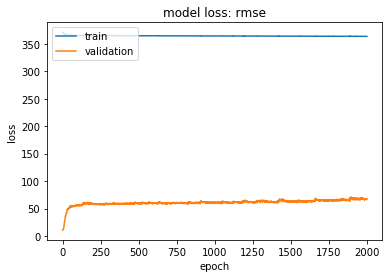

 
------ Experiment 2 ------
Metafeature set: tree
Standardization: regularize
regularize_y: False
Hidden neurons: 10
2nd hidden layer: True
2nd hidden has half neurons: False
Algo: RF
Nan method: mean


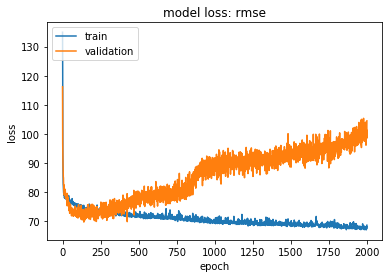

 
------ Experiment 3 ------
Metafeature set: tree
Standardization: regularize
regularize_y: False
Hidden neurons: 5
2nd hidden layer: False
Algo: XGboost
Nan method: drop


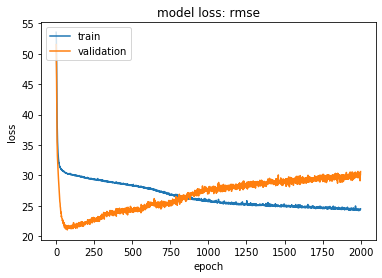

In [9]:
histories = {}
session = 'fit_pred' #'cv'
plot_true_preds = True
standardize = 'regularize'
hidden = 5
exp_counter = 0
for meta in ['tree', 'all']:
    for standardize_y in [False, True]:
        for algo in ['GLM', 'RF', 'XGboost']:
            exp_counter += 1
            #The bellow if statements are setting the optimal paramenters for the meta-model
            #according to the case in question.
            #----- Using ONLY tree metafeatures -----
            if meta == 'tree':
                if standardize_y:
                    if algo == 'GLM':
                        two_layers = True
                        half_on_second = False
                        method = 'drop'
                    elif algo == 'RF':
                        two_layers = True
                        half_on_second = True
                        method = 'drop'
                    elif algo =='XGboost':
                        two_layers = True
                        half_on_second = True
                        method = 'mean'
                else:
                    if algo == 'GLM':
                        two_layers = False
                        half_on_second = None
                        method = 'drop'
                    elif algo == 'RF':
                        two_layers = True
                        half_on_second = False
                        method = 'drop'
                    elif algo =='XGboost':
                        two_layers = False
                        half_on_second = None
                        method = 'mean'
            #----- Using BOTH tree + manual metafeatures -----
            elif meta =='all':
                if standardize_y:
                    if algo == 'GLM':
                        two_layers = True
                        half_on_second = True
                        method = 'drop'
                    elif algo == 'RF':
                        two_layers = True
                        half_on_second = True
                        method = 'drop'
                    elif algo =='XGboost':
                        two_layers = True
                        half_on_second = True
                        method = 'mean'
                else:
                    if algo == 'GLM':
                        two_layers = False
                        half_on_second = None
                        method = 'drop'
                    elif algo == 'RF':
                        two_layers = False
                        half_on_second = None
                        method = 'drop'
                    elif algo =='XGboost':
                        two_layers = False
                        half_on_second = None
                        method = 'mean'
            #Printing each experiment's configuration
            print('------ Experiment ' + str(exp_counter) + ' ------')
            print('Metafeature set:',meta)
            print('Standardization:',standardize)
            if standardize == 'regularize':
                print('regularize_y:',standardize_y)
            elif standardize == 'normalize':
                print('normalize_y:',standardize_y)
            print('Hidden neurons:', hidden)
            print('2nd hidden layer:',two_layers)
            if two_layers:
                print('2nd hidden has half neurons:',half_on_second)
            print('Algo:',algo)
            print('Nan method:',method)
    
            #Prepare the data
            if meta == 'all':
                input_dim = 45
                dataset = build_dataSet_DL(tree_meta_feature_path,
                                           ground_truth_path,
                                           manual_meta_feature_path = manual_meta_feature_path,
                                           algo = algo, method = method
                                          )
            elif meta == 'tree':
                input_dim = 15
                dataset = build_dataSet_DL(tree_meta_feature_path,
                                           ground_truth_path,
                                           algo = algo, method = method
                                          )
            #Creating train and test datasets according to predefined row indices.
            train = dataset.loc[train_indices,:]
            train.reset_index(drop=True, inplace = True)
            test = dataset.loc[test_indices,:]
            test.reset_index(drop=True, inplace = True)
            x_train, y_train = Data_prep(train, algo, method,
                                         regularization_path, normalization_path,
                                         standardize = standardize,
                                         regularize_y = standardize_y,
                                         normalize_y = standardize_y
                                        )
            x_test, y_test = Data_prep(test, algo, method,
                                       regularization_path, normalization_path,
                                       standardize = standardize)
    
            #Creating the model
            model = create_model(input_dim = input_dim, algo = algo, hidden = hidden,
                                 two_layers = two_layers, half_on_second = half_on_second
                                )
    
            #If doing crossvalidation session
            if session == 'cv':
                history = model.fit(x = x_train, y = y_train,
                                    validation_split = 0.15,
                                    epochs = 2000,
                                    batch_size = 5,
                                    verbose = 0
                                   )
                histories[exp_counter-1] = history
                plt.plot(np.sqrt(history.history['loss']))
                plt.plot(np.sqrt(history.history['val_loss']))
                plt.title('model loss: rmse')
                plt.ylabel('loss')
                plt.xlabel('epoch')
                plt.legend(['train', 'validation'], loc='upper left')
                plt.show()
        
            #If doing fit and predictions session
            elif session == 'fit_pred':
                es = EarlyStopping(monitor='val_loss',
                                   mode='min',
                                   patience = 500,
                                   verbose = 1
                                  )
                mc = ModelCheckpoint(model_path + '/best_model_' + algo + '_' + method +'.h5',
                                     monitor='val_loss',
                                     mode='min',
                                     verbose=0,
                                     save_best_only=True
                                    )
                history = model.fit(x = x_train, y = y_train,
                                    validation_split = 0.15,
                                    callbacks = [es, mc],
                                    epochs = 2000,
                                    batch_size = 5,
                                    verbose = 0)
                model = load_model(model_path + '/best_model_' + algo + '_' + method +'.h5')
                predictions = model.predict(x_test, verbose = 0)
                if standardize == 'regularize' and standardize_y:
                    predictions = deregularize_preds(predictions, algo, method, regularization_path)
                elif standardize == 'normalize' and standardize_y:        
                    predictions = denormalize_preds(predictions, algo, method, normalization_path)
                y_cols = predictions.shape[1]
                fig,a =  plt.subplots(1,y_cols,figsize=(20, 5))
                x = range(predictions.shape[0])
        
                y_lambda_values = []
                if algo == 'GLM':
                    y_lambda_values = np.concatenate([y_train[:,1],y_test[:,1]], axis=0)
                preds_fixed = fix_preds(predictions, algo, y_lambda_values)
                temp_rmse = []
                for target_column in range(y_cols):
                    #Plot ground truth
                    a[target_column].plot(x,y_test[:,target_column],'bo')
                    #Plotting quantized predictions
                    a[target_column].plot(x,preds_fixed[:,target_column],'yx')
                    if plot_true_preds:
                        a[target_column].plot(x,predictions[:,target_column],'r+')
                        a[target_column].legend(['ground truth', 'quantized preds', 'real preds'], loc='upper left')
                    else:
                        a[target_column].legend(['ground truth', 'quantized preds'], loc='upper left')                        
    
                    #Calculate rmse separately for each parameter
                    temp2 = math.sqrt(np.mean(np.square(preds_fixed[:,target_column] - y_test[:,target_column])))
                    print('RMSE for paramenter ' + str(target_column+1) + ': '+ str(round(10000*temp2)/10000) + ' scale is ' + str(round(10000*temp2/np.nanmax(y_test[:,target_column]))/100) + '%')
                plt.show()
            print(' ')

In [ ]:
#Run to zoom in at the cross validation learning curves
for i in range(len(histories)):
    plt.plot(np.sqrt(histories[i].history['loss'])[0:500])
    plt.plot(np.sqrt(histories[i].history['val_loss'])[0:500])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
#Run to save test and train indices
with open(path_to_dataset_folder + '/train_indices.csv', 'w') as f:
    for i,temp in enumerate(train_indices):
        if i < len(train_indices)-1:
            f.write(str(temp) + ',')
        else:
            f.write(str(temp))
            
with open(path_to_dataset_folder + '/test_indices.csv', 'w') as f:
    for i,temp in enumerate(test_indices):
        if i < len(test_indices)-1:
            f.write(str(temp) + ',')
        else:
            f.write(str(temp))

In [9]:
df = pd.read_csv(ground_truth_path + '/XGboost/processed_Seattle%temperature.csv')
df.head()

,ntrees_best,max_depth_best,cols_per_tree_best,rmse_best,ntrees_eco,max_depth_eco,cols_per_tree_eco,rmse_eco,calc_time
0,50,15,0.7,3.711495,25,15,0.7,3.744502,2183.763036
